In [2]:
import logging

import torch
from torch import optim
from torch.utils.data import DataLoader
from data.data_preparer import DataPreparer
from src.predictor.multilayer_perceptron import MultiLayerPerceptronPredictor
from src.predictor.neural_network_trainer import NeuralNetworkTrainer
from src.data.data_reader import DataReader
import os
import pandas as pd
from tools.RestaurantReviewsDataset import RestaurantReviewsDataset
from tools.config_parser import ConfigParser
from tools.profiles_manager import ProfilesManager
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

while str(os.getcwd())[-3:] != 'src':  # Execute from src-directory root
    os.chdir('..')

In [4]:
businesses, reviews, tips = DataReader().read_data()
user_profiles_list = ProfilesManager().get_user_profiles_names()


def get_trained_models_for_user_profiles(train_test_data_f: tuple, user_profiles_name_f: str):
    trained_models_f = []
    for model_location in os.scandir(ConfigParser().get_value('predictor_model', 'model_dir')):
        trained_model = MultiLayerPerceptronPredictor(input_size=train_test_data_f[0].columns.size, output_size=1)
        trained_optimizer = optim.Adam(trained_model.parameters(), lr=0.002)
        try:
            trained_model.load(trained_optimizer, model_location.path)
            if trained_model.user_profiles_location == user_profiles_name_f:
                trained_models_f.append((trained_model, trained_optimizer))
        except RuntimeError:
            pass
    return trained_models_f


def load_model(model_path: os.PathLike, businesses_f, reviews_f, tips_f):
    # Dummy model just to get the user profiles and business profiles
    user_profiles_location_f, business_profiles_location_f = MultiLayerPerceptronPredictor.get_profile_names(model_path)

    # Load appropriate data
    user_profiles_f = ProfilesManager().get_user_profiles(user_profiles_location_f)
    business_profiles_f = None if business_profiles_location_f in {"None", "", "none", None} else ProfilesManager().get_business_profiles(business_profiles_location_f)

    train_test_data_f = DataPreparer.get_train_test_validate(businesses_f, reviews_f, tips_f, user_profiles_f, business_profiles_f)

    # Create valid trained model
    trained_model = MultiLayerPerceptronPredictor(input_size=train_test_data_f[0].columns.size, output_size=1)
    trained_optimizer = optim.Adam(trained_model.parameters(), lr=0.002)
    trained_model.load(trained_optimizer, model_path)

    return trained_model, trained_optimizer, train_test_data_f


In [5]:
def get_all_models_with_loss():
    models_with_loss_f = []
    for dir_entry in os.scandir(ConfigParser().get_value("predictor_model", "model_dir")):
        model_path = dir_entry.path
        model_f, _, train_test_data_f = load_model(model_path, businesses, reviews, tips)
        models_with_loss_f.append((model_f, min(model.loss_history), train_test_data_f))


models_with_loss = get_all_models_with_loss()

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
def get_best_models(n: int = 5):
    all_models = get_all_models_with_loss()
    return sorted(all_models, key=lambda x: x[1])[:5]

best_models = get_best_models(5)
for i, (model, loss) in enumerate(best_models):
    model.plot_loss_progress(save_location=f"{i}_loss{loss}.png")

In [ ]:
# Old code
results = []

for model, _, train_test_data in best_models:
    logging.info(f"Testing model with User Profiles: {model.user_profiles_location} and Business Profiles: {model.business_profiles_location}")
    model.eval()  # Prepare layers of model for evaluation
    with torch.no_grad():
        testX, testY = train_test_data[1], train_test_data[3]

        testX = testX.head(500)
        testY = testY.head(500)

        dl = RestaurantReviewsDataset(testX.to_numpy(), testY.to_numpy())
        test_loader = DataLoader(dl, batch_size=500)
        for x, y in test_loader:
            # Prepare data
            x, y = DataPreparer.get_tensor_for_ml(x, y)
            # Compute predictions and loss

            predictions = model(x)
            predictions = predictions.cpu().detach().numpy().squeeze().transpose()
            y = y.cpu().detach().numpy().squeeze().transpose()
            result = pd.DataFrame(data=[predictions, y]).transpose()
            result.columns = ['predicted', 'actual']
            result['predicted'] = result['predicted'].transform(lambda x: round(x * 4 + 1))
            result['actual'] = result['actual'].transform(lambda x: int(x * 4 + 1))
            result['difference'] = abs(result['predicted'] - result['actual'])
            results.append(result)


Histogram of differences between prediction and actual:


(array([211., 232.,  49.,   7.,   1.]),
 array([0., 1., 2., 3., 4., 5.]),
 <BarContainer object of 5 artists>)

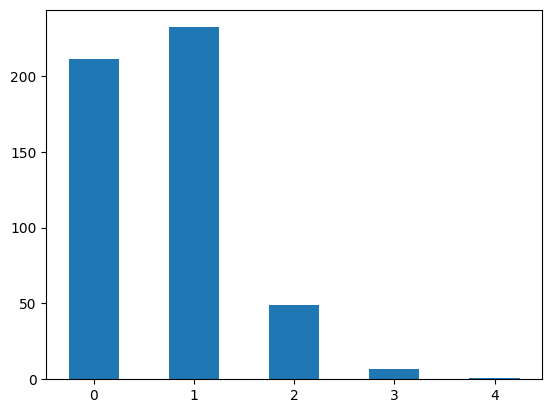

In [8]:
print()
print("Histogram of differences between prediction and actual:")
plt.hist(result['difference'], bins=[0, 1, 2, 3, 4, 5], align='left', rwidth=0.5)